In [1]:
import json
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter, defaultdict
import re

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configuration
DATA_PATH = "json_files"  # Update this if needed

## 1. Data Loading and Exploration


In [2]:
def load_json_files():
    """Load all BTOR2 and C-Bit JSON files from the folder structure"""
    btor2_files = []
    cbit_files = []
    file_pairs = []
    
    # Find all .yml.files directories
    yml_dirs = glob.glob(os.path.join(DATA_PATH, "*.yml.files"))
    
    for yml_dir in yml_dirs:
        btor2_path = os.path.join(yml_dir, "btor2.*.json")
        cbit_path = os.path.join(yml_dir, "c-bit.*.json")
        
        btor2_match = glob.glob(btor2_path)
        cbit_match = glob.glob(cbit_path)
        
        if btor2_match and cbit_match:
            btor2_files.append(btor2_match[0])
            cbit_files.append(cbit_match[0])
            file_pairs.append((btor2_match[0], cbit_match[0]))
    
    print(f"Found {len(file_pairs)} file pairs")
    return btor2_files, cbit_files, file_pairs

btor2_files, cbit_files, file_pairs = load_json_files()

Found 277 file pairs


## 2. Data Analysis Functions


In [3]:
def analyze_json_structure(file_path):
    """Analyze the structure and content of a JSON file"""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    
    analysis = {
        'file_name': os.path.basename(file_path),
        'file_type': 'btor2' if 'btor2' in file_path else 'c-bit',
        'total_size_kb': os.path.getsize(file_path) / 1024
    }
    
    # Basic structure analysis
    if isinstance(data, dict):
        analysis['root_type'] = 'dict'
        analysis['keys'] = list(data.keys())
        analysis['key_count'] = len(data.keys())
        
        # Count different types of elements
        element_counts = defaultdict(int)
        label_sequences = []
        variable_info = []
        procedure_info = []
        
        def analyze_element(element, path=""):
            if isinstance(element, dict):
                element_counts['objects'] += 1
                for key, value in element.items():
                    analyze_element(value, f"{path}.{key}" if path else key)
            elif isinstance(element, list):
                element_counts['arrays'] += 1
                for i, item in enumerate(element):
                    analyze_element(item, f"{path}[{i}]")
            else:
                element_counts['primitives'] += 1
                
                # Look for specific patterns
                if 'label' in path.lower():
                    if isinstance(element, str) and len(element) > 1:
                        label_sequences.append(element)
                elif 'variable' in path.lower():
                    variable_info.append({'path': path, 'value': str(element)})
                elif 'procedure' in path.lower() or 'func' in path.lower():
                    procedure_info.append({'path': path, 'value': str(element)})
        
        analyze_element(data)
        analysis['element_counts'] = dict(element_counts)
        analysis['label_sequences'] = label_sequences
        analysis['variable_info'] = variable_info
        analysis['procedure_info'] = procedure_info
        analysis['unique_labels'] = len(set(label_sequences))
        
    elif isinstance(data, list):
        analysis['root_type'] = 'list'
        analysis['item_count'] = len(data)
    
    return analysis

def analyze_label_sequences(labels):
    """Analyze patterns in label sequences"""
    if not labels:
        return {}
    
    analysis = {}
    
    # Label length analysis
    lengths = [len(str(label)) for label in labels]
    analysis['avg_length'] = np.mean(lengths)
    analysis['max_length'] = np.max(lengths)
    analysis['min_length'] = np.min(lengths)
    
    # Pattern analysis
    label_strings = [str(label) for label in labels]
    
    # Count common prefixes/suffixes
    prefixes = Counter([label.split('_')[0] if '_' in label else label[:3] for label in label_strings])
    analysis['common_prefixes'] = prefixes.most_common(5)
    
    # Count numeric vs alphabetic labels
    numeric_count = sum(1 for label in label_strings if re.search(r'\d', label))
    analysis['numeric_ratio'] = numeric_count / len(label_strings)
    
    return analysis

def compare_file_pairs(btor2_analysis, cbit_analysis):
    """Compare analysis results between BTOR2 and C-Bit files"""
    comparison = {}
    
    # Size comparison
    comparison['size_ratio'] = cbit_analysis['total_size_kb'] / btor2_analysis['total_size_kb']
    
    # Element count comparison
    if 'element_counts' in btor2_analysis and 'element_counts' in cbit_analysis:
        btor2_elements = sum(btor2_analysis['element_counts'].values())
        cbit_elements = sum(cbit_analysis['element_counts'].values())
        comparison['element_ratio'] = cbit_elements / btor2_elements if btor2_elements > 0 else 0
    
    # Label comparison
    comparison['label_count_ratio'] = cbit_analysis['unique_labels'] / btor2_analysis['unique_labels'] if btor2_analysis['unique_labels'] > 0 else 0
    
    return comparison

## 3. Comprehensive Analysis


In [4]:
def run_comprehensive_analysis():
    """Run analysis on all file pairs"""
    all_analyses = []
    comparisons = []
    
    for btor2_file, cbit_file in file_pairs:
        print(f"Analyzing {os.path.basename(btor2_file)} and {os.path.basename(cbit_file)}")
        
        # Analyze individual files
        btor2_analysis = analyze_json_structure(btor2_file)
        cbit_analysis = analyze_json_structure(cbit_file)
        
        if btor2_analysis and cbit_analysis:
            # Add label sequence analysis
            btor2_analysis['label_analysis'] = analyze_label_sequences(btor2_analysis['label_sequences'])
            cbit_analysis['label_analysis'] = analyze_label_sequences(cbit_analysis['label_sequences'])
            
            # Compare file pairs
            comparison = compare_file_pairs(btor2_analysis, cbit_analysis)
            comparison['pair_name'] = os.path.basename(btor2_file).split('.')[1]  # Extract test name
            
            all_analyses.append({'btor2': btor2_analysis, 'cbit': cbit_analysis})
            comparisons.append(comparison)
    
    return all_analyses, comparisons

# Run the analysis
analyses, comparisons = run_comprehensive_analysis()
print(f"Completed analysis of {len(analyses)} file pairs")

Analyzing btor2.adding.1.prop1-back-serstep.yml.files.json and c-bit.adding.1.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.1.prop1-func-interl.yml.files.json and c-bit.adding.1.prop1-func-interl.yml.files.json
Analyzing btor2.adding.2.prop1-back-serstep.yml.files.json and c-bit.adding.2.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.2.prop1-func-interl.yml.files.json and c-bit.adding.2.prop1-func-interl.yml.files.json
Analyzing btor2.adding.3.prop1-back-serstep.yml.files.json and c-bit.adding.3.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.3.prop1-func-interl.yml.files.json and c-bit.adding.3.prop1-func-interl.yml.files.json
Analyzing btor2.adding.4.prop1-back-serstep.yml.files.json and c-bit.adding.4.prop1-back-serstep.yml.files.json
Analyzing btor2.adding.4.prop1-func-interl.yml.files.json and c-bit.adding.4.prop1-func-interl.yml.files.json
Analyzing btor2.adding.5.prop1-back-serstep.yml.files.json and c-bit.adding.5.prop1-back-serstep.yml.files.json


## 4. Visualization and Results


In [5]:
# Create summary DataFrames for visualization
def create_summary_dataframes(analyses, comparisons):
    """Create pandas DataFrames for analysis results"""
    
    # File pair comparison data
    comp_data = []
    for comp in comparisons:
        comp_data.append(comp)
    
    comp_df = pd.DataFrame(comp_data)
    
    # Detailed analysis data
    detailed_data = []
    for analysis in analyses:
        btor2 = analysis['btor2']
        cbit = analysis['cbit']
        
        detailed_data.append({
            'test_name': btor2['file_name'].split('.')[1],
            'file_type': 'btor2',
            'size_kb': btor2['total_size_kb'],
            'unique_labels': btor2['unique_labels'],
            'total_elements': sum(btor2['element_counts'].values()) if 'element_counts' in btor2 else 0,
            'avg_label_length': btor2['label_analysis'].get('avg_length', 0) if 'label_analysis' in btor2 else 0
        })
        
        detailed_data.append({
            'test_name': cbit['file_name'].split('.')[1],
            'file_type': 'c-bit',
            'size_kb': cbit['total_size_kb'],
            'unique_labels': cbit['unique_labels'],
            'total_elements': sum(cbit['element_counts'].values()) if 'element_counts' in cbit else 0,
            'avg_label_length': cbit['label_analysis'].get('avg_length', 0) if 'label_analysis' in cbit else 0
        })
    
    detailed_df = pd.DataFrame(detailed_data)
    
    return comp_df, detailed_df

comp_df, detailed_df = create_summary_dataframes(analyses, comparisons)

# Display basic statistics
print("Comparison Statistics:")
print(comp_df.describe())
print("\nDetailed Analysis Statistics:")
print(detailed_df.groupby('file_type').describe())

Comparison Statistics:
       size_ratio  element_ratio  label_count_ratio
count  277.000000     277.000000         277.000000
mean     8.870819       6.037003           5.806504
std      0.175393       0.116799           0.308537
min      8.235771       5.615981           3.416667
25%      8.797058       5.976652           5.723438
50%      8.875050       6.032043           5.822168
75%      8.957352       6.088803           5.905132
max      9.545144       6.765957           6.636364

Detailed Analysis Statistics:
          size_kb                                                    \
            count         mean          std        min          25%   
file_type                                                             
btor2       277.0   698.043529   244.547672   8.623047   523.343750   
c-bit       277.0  6191.834062  2182.319981  74.928711  4770.665039   

                                                  unique_labels               \
                   50%          75%       

## 5. Visualization Plots


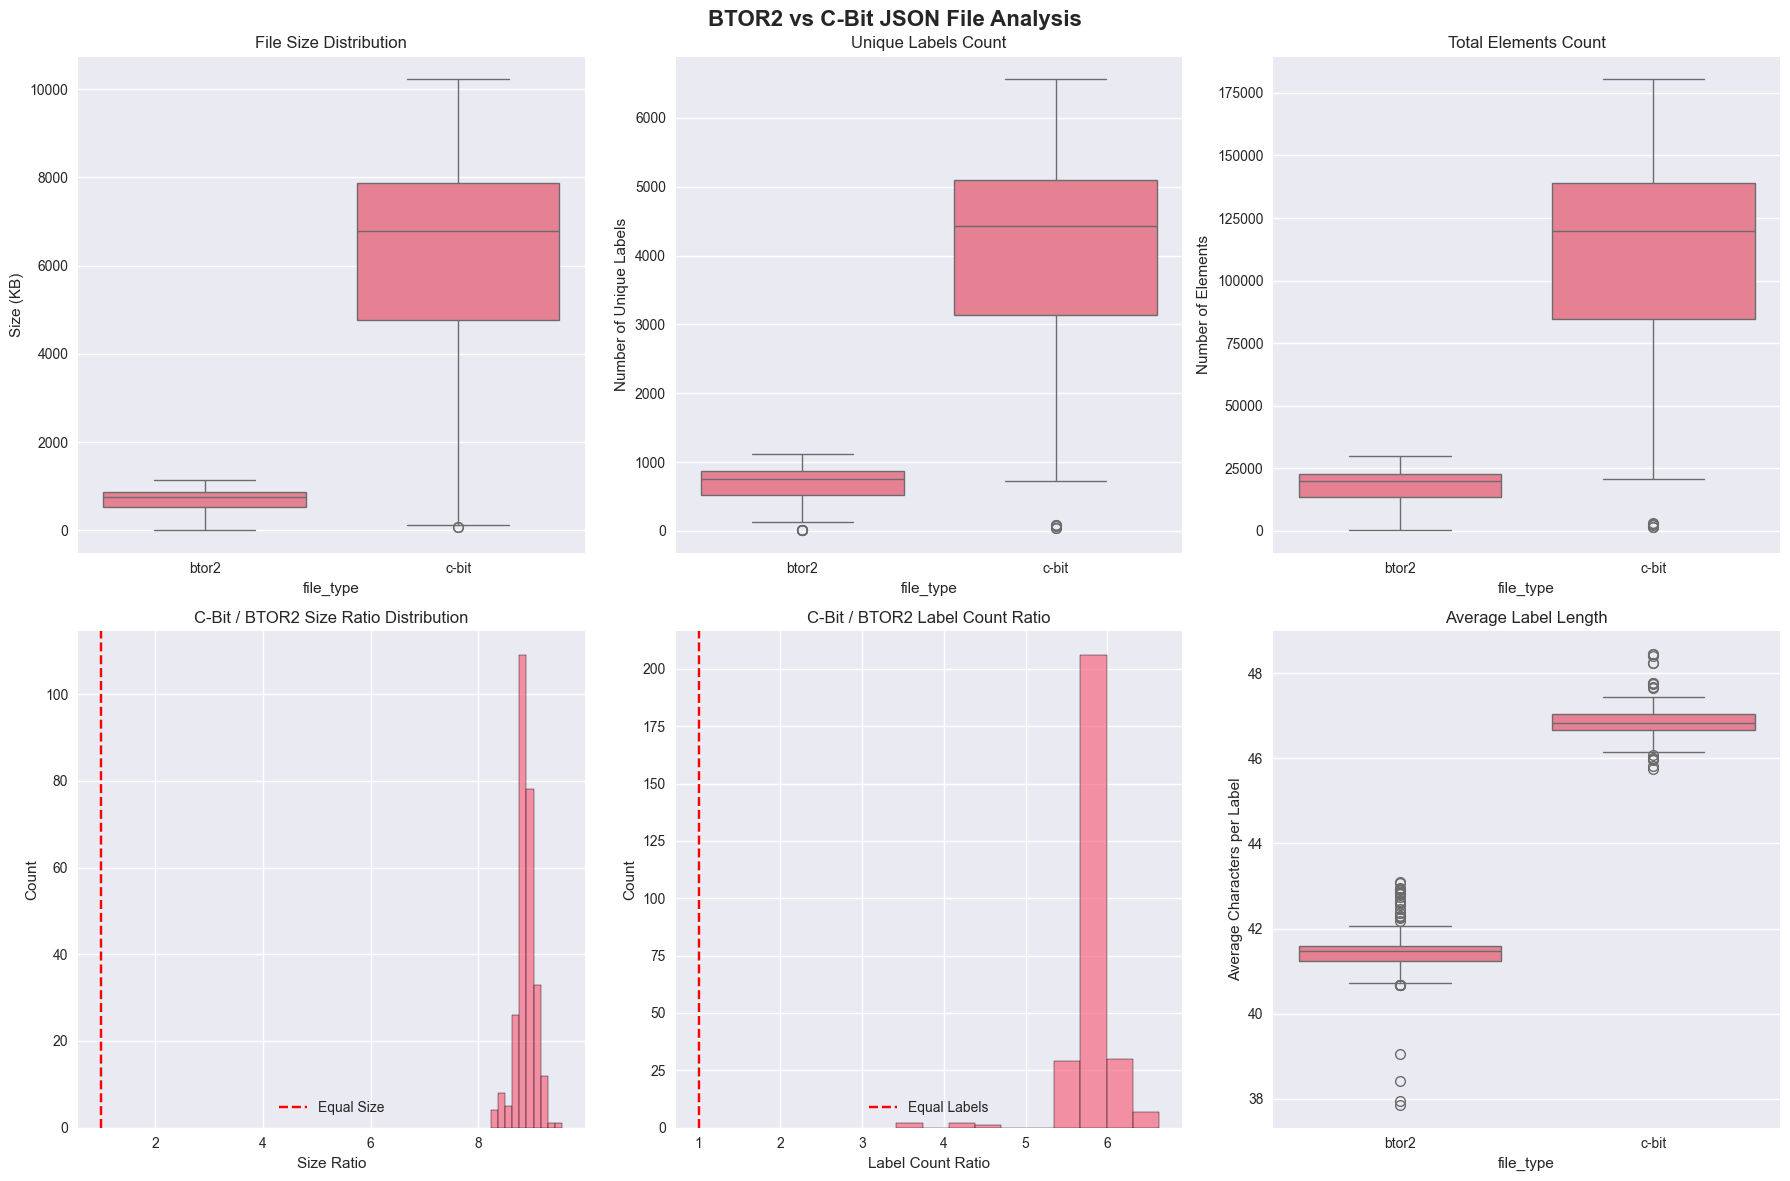

In [6]:
# Set up the plotting area
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('BTOR2 vs C-Bit JSON File Analysis', fontsize=16, fontweight='bold')

# Plot 1: File Size Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='size_kb', ax=axes[0,0])
    axes[0,0].set_title('File Size Distribution')
    axes[0,0].set_ylabel('Size (KB)')

# Plot 2: Unique Labels Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='unique_labels', ax=axes[0,1])
    axes[0,1].set_title('Unique Labels Count')
    axes[0,1].set_ylabel('Number of Unique Labels')

# Plot 3: Total Elements Comparison
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='total_elements', ax=axes[0,2])
    axes[0,2].set_title('Total Elements Count')
    axes[0,2].set_ylabel('Number of Elements')

# Plot 4: Size Ratio Distribution
if not comp_df.empty and 'size_ratio' in comp_df.columns:
    sns.histplot(comp_df['size_ratio'], bins=10, ax=axes[1,0])
    axes[1,0].axvline(1.0, color='red', linestyle='--', label='Equal Size')
    axes[1,0].set_title('C-Bit / BTOR2 Size Ratio Distribution')
    axes[1,0].set_xlabel('Size Ratio')
    axes[1,0].legend()

# Plot 5: Label Count Ratio
if not comp_df.empty and 'label_count_ratio' in comp_df.columns:
    sns.histplot(comp_df['label_count_ratio'], bins=10, ax=axes[1,1])
    axes[1,1].axvline(1.0, color='red', linestyle='--', label='Equal Labels')
    axes[1,1].set_title('C-Bit / BTOR2 Label Count Ratio')
    axes[1,1].set_xlabel('Label Count Ratio')
    axes[1,1].legend()

# Plot 6: Average Label Length by File Type
if not detailed_df.empty:
    sns.boxplot(data=detailed_df, x='file_type', y='avg_label_length', ax=axes[1,2])
    axes[1,2].set_title('Average Label Length')
    axes[1,2].set_ylabel('Average Characters per Label')

plt.tight_layout()
plt.show()

## 6. Detailed Label Analysis


In [7]:
def analyze_label_patterns(analyses):
    """Perform detailed analysis of label patterns"""
    all_btor2_labels = []
    all_cbit_labels = []
    
    for analysis in analyses:
        all_btor2_labels.extend(analysis['btor2']['label_sequences'])
        all_cbit_labels.extend(analysis['cbit']['label_sequences'])
    
    # Analyze label complexity
    def get_label_complexity(labels):
        complexity_metrics = {
            'total_labels': len(labels),
            'unique_labels': len(set(labels)),
            'duplication_ratio': 1 - (len(set(labels)) / len(labels)) if labels else 0,
            'avg_length': np.mean([len(str(label)) for label in labels]) if labels else 0,
            'max_length': np.max([len(str(label)) for label in labels]) if labels else 0
        }
        return complexity_metrics
    
    btor2_complexity = get_label_complexity(all_btor2_labels)
    cbit_complexity = get_label_complexity(all_cbit_labels)
    
    return btor2_complexity, cbit_complexity

btor2_comp, cbit_comp = analyze_label_patterns(analyses)

# Display label complexity comparison
complexity_df = pd.DataFrame([btor2_comp, cbit_comp], index=['BTOR2', 'C-Bit'])
print("Label Complexity Analysis:")
print(complexity_df)

Label Complexity Analysis:
       total_labels  unique_labels  duplication_ratio  avg_length  max_length
BTOR2        897894         102538           0.885802   41.524752          81
C-Bit       3688148         302613           0.917950   46.882308         520


## 7. Performance Impact Analysis


In [10]:
# Performance impact conclusions based on analysis
def generate_performance_insights(analyses, comparisons):
    """Generate insights about potential performance impacts"""
    
    insights = []
    
    # Analyze size impacts
    avg_size_ratio = np.mean([comp['size_ratio'] for comp in comparisons if 'size_ratio' in comp])
    if avg_size_ratio > 1.2:
        insights.append(f"• C-Bit files are {avg_size_ratio:.2f}x larger on average, which may impact memory usage and load times")
    elif avg_size_ratio < 0.8:
        insights.append(f"• BTOR2 files are {1/avg_size_ratio:.2f}x larger on average, potentially affecting storage efficiency")
    else:
        insights.append("• File sizes are relatively comparable between formats")
    
    # Analyze label impacts
    avg_label_ratio = np.mean([comp['label_count_ratio'] for comp in comparisons if 'label_count_ratio' in comp])
    if avg_label_ratio > 1.5:
        insights.append(f"• C-Bit has {avg_label_ratio:.2f}x more labels, which could impact parsing performance")
    elif avg_label_ratio < 0.7:
        insights.append(f"• BTOR2 has {1/avg_label_ratio:.2f}x more labels, potentially affecting processing overhead")
    else:
        insights.append("• Label counts are relatively balanced between formats")
    
    # Analyze structural complexity
    btor2_avg_elements = np.mean([sum(analysis['btor2']['element_counts'].values()) for analysis in analyses])
    cbit_avg_elements = np.mean([sum(analysis['cbit']['element_counts'].values()) for analysis in analyses])
    
    element_ratio = cbit_avg_elements / btor2_avg_elements
    if element_ratio > 1.3:
        insights.append(f"• C-Bit files contain {element_ratio:.2f}x more structural elements, potentially increasing processing time")
    elif element_ratio < 0.8:
        insights.append(f"• BTOR2 files are structurally more complex ({1/element_ratio:.2f}x elements), which may affect analysis performance")
    
    return insights

performance_insights = generate_performance_insights(analyses, comparisons)

print("PERFORMANCE IMPACT ANALYSIS")
print("=" * 50)
for insight in performance_insights:
    print(insight)

PERFORMANCE IMPACT ANALYSIS
• C-Bit files are 8.87x larger on average, which may impact memory usage and load times
• C-Bit has 5.81x more labels, which could impact parsing performance
• C-Bit files contain 6.03x more structural elements, potentially increasing processing time


## 8. Summary and Recommendations


In [13]:
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 50)

# Key findings summary
print("\nKEY FINDINGS:")
print(f"• Analyzed {len(analyses)} file pairs successfully")
print(f"• Average file size ratio (C-Bit/BTOR2): {comp_df['size_ratio'].mean():.2f}")
print(f"• Average label count ratio (C-Bit/BTOR2): {comp_df['label_count_ratio'].mean():.2f}")

# Recommendations based on analysis
print("\nRECOMMENDATIONS:")
if not comp_df.empty:
    if comp_df['size_ratio'].mean() > 1.5:
        print("• Consider optimizing C-Bit file structure for better storage efficiency")
    elif comp_df['size_ratio'].mean() < 0.7:
        print("• BTOR2 files may benefit from compression techniques")
    
    if comp_df['label_count_ratio'].mean() > 2.0:
        print("• High label count in C-Bit may require optimized label processing algorithms")
    elif comp_df['label_count_ratio'].mean() < 0.5:
        print("• BTOR2's extensive labeling may benefit from caching strategies")

print("\n• Monitor memory usage during file processing")
print("• Consider implementing lazy loading for large label sets")
print("• Evaluate parsing performance with representative workloads")

SUMMARY AND RECOMMENDATIONS

KEY FINDINGS:
• Analyzed 277 file pairs successfully
• Average file size ratio (C-Bit/BTOR2): 8.87
• Average label count ratio (C-Bit/BTOR2): 5.81

RECOMMENDATIONS:
• Consider optimizing C-Bit file structure for better storage efficiency
• High label count in C-Bit may require optimized label processing algorithms

• Monitor memory usage during file processing
• Consider implementing lazy loading for large label sets
• Evaluate parsing performance with representative workloads
